In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from simulate_triple import simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

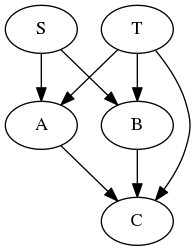

In [4]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S', 'T'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B'), ('T', 'A'), ('T', 'B'), ('T', 'C')])
draw(G, show='ipynb')

In [5]:
data = simulate(stop_time=600, record_state=True, ac_amp=1., ac_offset=-.5, pbar=tqdm)

HBox(children=(IntProgress(value=0, max=9478), HTML(value='')))

In [6]:
state = data['state'].groupby('senders')
spiketrains = data['spiketrains'].groupby('senders')

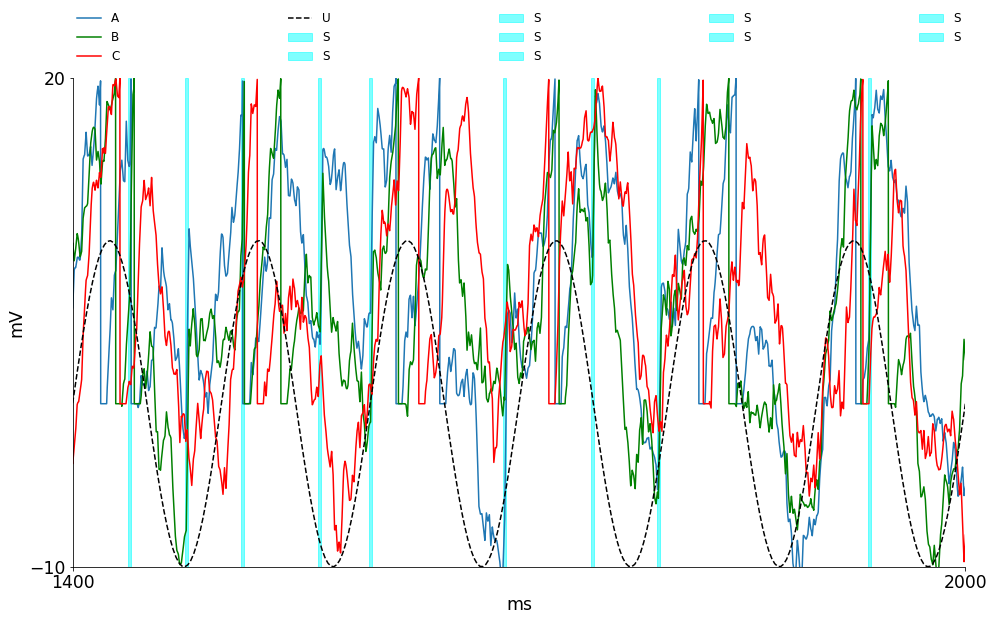

In [7]:
plt.figure(figsize=(16,9))
xlim = [1400, 2000]
ylim = [-10, 20]
mask_s = (data['stim_times'] > xlim[0]) & (data['stim_times'] < xlim[1])
plt.plot(state.get_group(1).times, state.get_group(1).V_m, label='A')
plt.plot(state.get_group(2).times, state.get_group(2).V_m, 'g', label='B')
plt.plot(state.get_group(3).times, state.get_group(3).V_m, 'r', label='C')
for s in data['stim_times'][mask_s]:
    plt.axvspan(s, s+2, alpha=.5, color='cyan', label='S')
    
t = np.linspace(0, xlim[-1], 1000)
ac = 10 * np.sin(2 * np.pi * data['params']['ac_freq'] * t)
plt.plot(t, ac, '--k', label='U')
plt.xlim(xlim)
plt.xlabel('ms')
plt.ylabel('mV')

plt.ylim(ylim)
plt.legend(
    frameon=False,
    bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    mode="expand", borderaxespad=0, ncol=5, fontsize='large')

plt.gca().set_yticks(ylim)
plt.gca().set_xticks(xlim)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

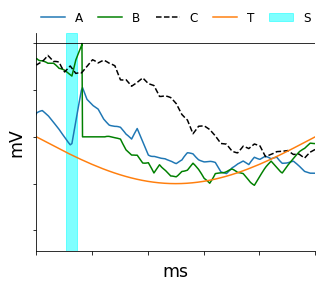

In [8]:
plt.figure(figsize=(5,4))
xlim = [950, 1000]
mask_s = (data['stim_times'] > xlim[0]) & (data['stim_times'] < xlim[1])
plt.plot(state.get_group(1).times, state.get_group(1).V_m, label='A')
plt.plot(state.get_group(2).times, state.get_group(2).V_m, 'g', label='B')
plt.plot(state.get_group(3).times, state.get_group(3).V_m, '--k', label='C')
for s in data['stim_times'][mask_s]:
    plt.axvspan(s, s+2, alpha=.5, color='cyan', label='S')
    
t = np.linspace(0, 1000, 1000)
ac = 10 * np.sin(2 * np.pi * data['params']['ac_freq'] * t)
plt.plot(t, ac, label='T')
plt.xlim(xlim)
plt.xlabel('ms')
plt.ylabel('mV')
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.ylim(-5, 20)
plt.legend(
    frameon=False,
    bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
    mode="expand", borderaxespad=0, ncol=5, fontsize='large')
plt.axhline(20, color='k', lw=.8)

In [9]:
from causal_optoconnectics.core import find_first_response_spike, find_response_spikes

In [10]:
A = spiketrains.get_group(1)['times'].to_numpy()
B = spiketrains.get_group(2)['times'].to_numpy()
C = spiketrains.get_group(3)['times'].to_numpy()

# Z_A, X_A, Y_A, stim_times_A = find_first_response_spike(A, C, data['stim_times'])
# Z_B, X_B, Y_B, stim_times_B = find_first_response_spike(B, C, data['stim_times'])

# Z_A, X_A, Y_A = Z_A[:-2], X_A[:-2], Y_A[:-2]
# print(X_A.shape)

In [11]:
%timeit find_first_response_spike(A, C, data['stim_times'])

479 µs ± 3.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit find_response_spikes(A, C, data['stim_times'], dt=.01, dz=1e-3)

161 ms ± 6.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
Z_A, X_A, Y_A = find_response_spikes(A, C, data['stim_times'], dt=30, dz=1)
Z_B, X_B, Y_B = find_response_spikes(B, C, data['stim_times'], dt=30, dz=1)

(0, 30)

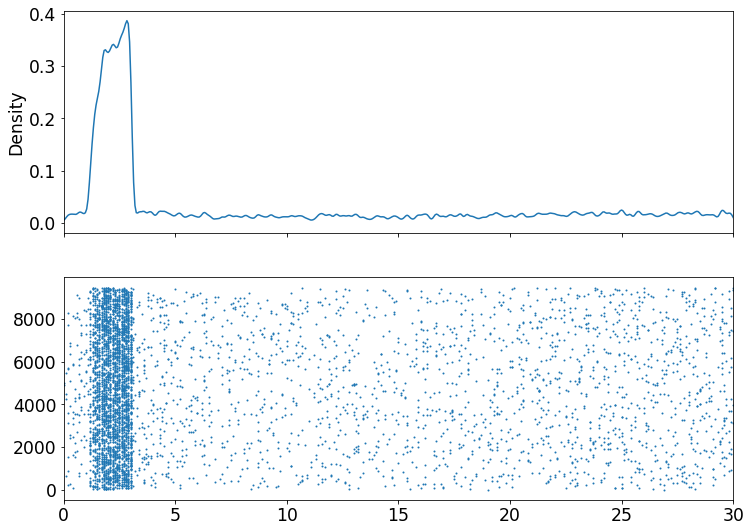

In [25]:
spike_trials_XA = [t for trial in X_A for t in trial]
spike_ids_XA = [t for i, trial in enumerate(X_A) for t in [i]*len(trial)]
fig, axs = plt.subplots(2,1, sharex=True)
pd.Series(spike_trials_XA).plot.kde(ax=axs[0], bw_method=.01)
axs[1].scatter(spike_trials_XA, spike_ids_XA, s=1)
plt.xlim(0,30)

In [ ]:
plt.scatter(X_A, X_B)

In [ ]:
plt.hist(Y_B, bins=np.arange(0,15,.1));
plt.hist(X_B, bins=np.arange(0,15,.1));
plt.figure()
plt.hist(Y_A, bins=np.arange(0,15,.1));
plt.hist(X_A, bins=np.arange(0,15,.1));

In [ ]:
def calculate_response(Z, X, Y, x1, x2, y1, y2, z1):
    XX = ((X > x1) & (X < x2)).astype(int)                                                                                                         
    YY = ((Y > y1) & (Y < y2)).astype(int)
    ZZ = (abs(Z) < z1).astype(int)
    assert sum(XX[ZZ==1]) == 0
    return ZZ, XX, YY


def calculate_rate(
    x, y, stim_times, x1, x2, y1, y2):
    stim_times = stim_times.astype(float)

    stim_win = np.insert(
        stim_times + y1,
        np.arange(len(stim_times)) + 1,
        stim_times + y2)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten() / (y2-y1) * 1000
    
    stim_win = np.insert(
        stim_times + x1,
        np.arange(len(stim_times)) + 1,
        stim_times + x2)
    src_x = np.searchsorted(x, stim_win, side='left')
    cnt_x = np.diff(src_x.reshape((int(len(src_x) / 2), 2)))
    X = cnt_x.flatten() / (x2 - x1) * 1000

    return X, Y

In [ ]:
ZZ_A, XX_A, YY_A = calculate_response(Z_A, X_A, Y_A, 1, 3, 4, 8, 1) 
ZZ_B, XX_B, YY_B = calculate_response(Z_B, X_B, Y_B, 1, 3, 4, 8, 1) 

In [ ]:
RX_A, RY_A = calculate_rate(A, C, data['stim_times'], 1, 3, 4, 8) 
RX_B, RY_B = calculate_rate(B, C, data['stim_times'], 1, 3, 4, 8) 

n=1
RX_A, RY_A = RX_A[:-n], RY_A[:-n]
RX_B, RY_B = RX_B[:-n], RY_B[:-n]

In [ ]:
def wald(ZZ, XX, YY):
    print(YY[ZZ==1].mean(),YY[ZZ==0].mean(),XX[ZZ==1].mean(), XX[ZZ==0].mean())
    return (YY[ZZ==1].mean() - YY[ZZ==0].mean()) / (XX[ZZ==1].mean() - XX[ZZ==0].mean())

def cond(ZZ, XX, YY):
    return (YY[XX==1].mean() - YY[XX==0].mean())

In [ ]:
wald(ZZ_A, RX_A, RY_A), wald(ZZ_A, XX_A, YY_A), cond(ZZ_A, XX_A, YY_A)

In [ ]:
wald(ZZ_B, RX_B, RY_B), wald(ZZ_B, XX_B, YY_B), cond(ZZ_B, XX_B, YY_B)

In [ ]:
np.cov(ZZ_A, ZZ_B)[0,1]

In [ ]:
def wald_density(x, y, stim_times, x1, x2, y1, y2, z1):
    Z, X, Y, stim_times = calculate_regressors(x, y, stim_times)
    XX = ((X > x1) & (X < x2)).astype(int)                                                                                                         
    YY = ((Y > y1) & (Y < y2)).astype(int)
    ZZ = (abs(Z) < z1).astype(int)
    assert sum(XX[ZZ==1]) == 0

    X0 = st.norm.pdf(X[ZZ==0])
    X1 = st.norm.pdf(X[ZZ==1])
    Y0 = st.norm.pdf(Y[ZZ==0])
    Y1 = st.norm.pdf(Y[ZZ==1])
#     bins = bins[:-1]
#     mask_y = (bins >= y1) & (bins <= y2)
#     mask_x = (bins >= x1) & (bins <= x2)
    ev = lambda x: np.trapz(x, dx=binsize)
#     assert abs(ev(X0) - 1) < 1e-2, ev(X0)
    plt.plot(Y1, label='Y,Z=1', alpha=.5)
    plt.plot(Y0, label='Y,Z=0', alpha=.5)
    plt.plot(X1, label='X,Z=1', alpha=.5)
    plt.plot(X0, label='X,Z=0', alpha=.5)
    plt.legend()
    Y1 = ev(Y1[mask_y]) / len(mask_y)
    Y0 = ev(Y0[mask_y]) / len(mask_y)
#     X1 = ev(X1[mask_x]) / len(mask_x) 
    X0 = ev(X0[mask_x]) / len(mask_y)
    
    return Y1, Y0,  X0

In [ ]:
def cond_density(x, y, stim_times, x1, x2, y1, y2):
    _, X, Y, stim_times = calculate_regressors(x, y, stim_times)
    XX = ((X > x1) & (X < x2)).astype(int)                                                                                                         
    YY = ((Y > y1) & (Y < y2)).astype(int)
    binsize = .1
    bins = np.arange(0, 25, binsize)
    Y0, _ = np.histogram(Y[XX==0], bins=bins, density=True)
    Y1, _ = np.histogram(Y[XX==1], bins=bins, density=True)
    bins = bins[:-1] + binsize / 2
    mask_y = (bins >= y1) & (bins <= y2)
    mask_x = (bins >= x1) & (bins <= x2)
    ev = lambda x: np.trapz(x, dx=binsize)
    plt.figure()
    plt.bar(bins, Y1, align='edge', width=-binsize, label='X=1', alpha=.5)
    plt.bar(bins, Y0, align='edge', width=-binsize, label='X=0', alpha=.5)
    Y1 = ev(Y1[mask_y]) / len(mask_y)
    Y0 = ev(Y0[mask_y]) / len(mask_y)
    
    return Y1 - Y0

In [ ]:
y11, y10, x10 = wald_density(A, C, data['stim_times'], 1, 3, 4, 8, 1)
y21, y20, x20 = wald_density(A, C, data['stim_times']-25, 1, 3, 4, 8, 1)
((y11 - y21) - (y10 - y20)) / -(x10 - x20)

In [ ]:
y11, y10, x10 = wald_density(B, C, data['stim_times'], 1, 3, 4, 8, 1)
y21, y20, x20 = wald_density(B, C, data['stim_times']-25, 1, 3, 4, 8, 1)
((y11 - y21) - (y10 - y20)) / -(x10 - x20)

In [ ]:
y11, y10 = cond_density(A, C, data['stim_times'], 1, 3, 4, 8)
y21, y20 = cond_density(A, C, data['stim_times']-25, 1, 3, 4, 8)
((y11 - y21) - (y10 - y20))

In [ ]:
y11, y10 = cond_density(B, C, data['stim_times'], 1, 3, 4, 8)
y21, y20 = cond_density(B, C, data['stim_times']-25, 1, 3, 4, 8)
((y11 - y21) - (y10 - y20)) 

In [ ]:
plt.hist(Y_A[XX_A==0], bins=np.arange(0,15,.1), alpha=.5, label='X=0', density=True);
plt.hist(Y_A[XX_A==1], bins=np.arange(0,15,.1), alpha=.5, label='X=1', density=True);
plt.legend()
plt.figure()
plt.hist(Y_B[XX_B==0], bins=np.arange(0,15,.1), alpha=.5, label='X=0', density=True);
plt.hist(Y_B[XX_B==1], bins=np.arange(0,15,.1), alpha=.5, label='X=1', density=True);
plt.legend()


In [ ]:
plt.hist(Y_A[ZZ_A==0], bins=np.arange(0,15,.1), alpha=.5, label='Z=0', density=True);
plt.hist(Y_A[ZZ_A==1], bins=np.arange(0,15,.1), alpha=.5, label='Z=1', density=True);
plt.legend()
plt.figure()
plt.hist(Y_B[ZZ_B==0], bins=np.arange(0,15,.1), alpha=.5, label='Z=0', density=True);
plt.hist(Y_B[ZZ_B==1], bins=np.arange(0,15,.1), alpha=.5, label='Z=1', density=True);
plt.legend()



In [5]:
J_ACs = np.arange(0, 7.1, .1)
simulations_J_AC = defaultdict(list)
for a in tqdm(J_ACs):
    data = simulate(stop_time=4000, J_AC=a, ac_amp=1., ac_offset=-.5, pbar=lambda x:x)
    stop_time = data['status']['time']
    spiketrains = data['spiketrains'].groupby('senders')
    A_spikes = spiketrains.get_group(1)['times'].to_numpy()
    B_spikes = spiketrains.get_group(2)['times'].to_numpy()
    C_spikes = spiketrains.get_group(3)['times'].to_numpy()
    
    simulations_J_AC['stim_times'].append(data['stim_times'])
    simulations_J_AC['A_spikes'].append(A_spikes)
    simulations_J_AC['B_spikes'].append(B_spikes)
    simulations_J_AC['C_spikes'].append(C_spikes)
    simulations_J_AC['stop_time'].append(stop_time)
    simulations_J_AC['J_AC'].append(a)

np.savez('simulations_J_AC_osc.npz', data=simulations_J_AC)
# simulations_J_AC = np.load('simulations_J_AC_osc.npz', allow_pickle=True)['data'][()]

HBox(children=(IntProgress(value=0, max=71), HTML(value='')))

In [118]:
# def wald_density(x, y, stim_times, x1, x2, y1, y2, z1):
#     stim_times = stim_times.astype(float)

#     src_x = np.searchsorted(x, stim_times, side='right')
#     src_y = np.searchsorted(y, stim_times, side='right')

#     remove_idxs, = np.where(
#         (src_x==len(x)) | (src_y==len(y)))
#     src_x = np.delete(src_x, remove_idxs)
#     src_y = np.delete(src_y, remove_idxs)
#     stim_times = np.delete(stim_times, remove_idxs)

#     X = x[src_x] - stim_times
#     Y = y[src_y] - stim_times
#     Z = x[src_x-1] - stim_times
#     Yn = y[src_y-1] - stim_times
    
#     XX = ((X > x1) & (X < x2)).astype(int)
#     ZZ = (abs(Z) < z1).astype(int)
#     assert sum(XX[ZZ==1]) == 0
#     X0 = np.concatenate([Z[ZZ==0], X[ZZ==0]])
#     X1 = np.concatenate([Z[ZZ==1], X[ZZ==1]])
#     Y0 = np.concatenate([Yn[ZZ==0], Y[ZZ==0]])
#     Y1 = np.concatenate([Yn[ZZ==1], Y[ZZ==1]])
    
#     binsize = .1
#     bins = np.arange(-20, 20, binsize)
#     density=True
#     X0, _ = np.histogram(X0, bins=bins, density=density)
#     X1, _ = np.histogram(X1, bins=bins, density=density)
#     Y0, _ = np.histogram(Y0, bins=bins, density=density)
#     Y1, _ = np.histogram(Y1, bins=bins, density=density)
#     bins = bins[1:]
    
#     ev = lambda x: np.trapz(x, dx=binsize)
#     assert abs(ev(X0) - 1) < 1e-2, ev(X0)
    
#     mask_y = (bins >= y1) & (bins <= y2)
#     mask_x = (bins >= x1) & (bins <= x2)
#     Y11 = ev(Y1[mask_y]) / len(mask_y)
#     Y10 = ev(Y0[mask_y]) / len(mask_y)
#     X10 = ev(X0[mask_x]) / len(mask_y)
    
#     mask_y = (bins >= -y1) & (bins <= -y2)
#     mask_x = (bins >= -x1) & (bins <= -x2)
#     Y01 = ev(Y1[mask_y]) / len(mask_y)
#     Y00 = ev(Y0[mask_y]) / len(mask_y)
#     X00 = ev(X0[mask_x]) / len(mask_y)
    
#     return ((Y11 - Y01) - (Y10 - Y00)) / - (X10 - X00)


def wald_density(x, y, stim_times, x1, x2, y1, y2, z1, limit=10):
    stim_times = stim_times.astype(float)

    src_x = np.searchsorted(x, stim_times, side='right')
    src_y = np.searchsorted(y, stim_times, side='right')

    remove_idxs, = np.where(
        (src_x==len(x)) | (src_y==len(y)))
    src_x = np.delete(src_x, remove_idxs)
    src_y = np.delete(src_y, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)

    X = x[src_x] - stim_times
    Y = y[src_y] - stim_times
    Z = x[src_x-1] - stim_times
    
    XX = ((X > x1) & (X < x2)).astype(int)
    ZZ = (abs(Z) < z1).astype(int)
    assert sum(XX[ZZ==1]) == 0
    
    X0 =  X[ZZ==0]
    Y0 = Y[ZZ==0]
    Y1 = Y[ZZ==1]
    
    KX0 = st.gaussian_kde(X0[(X0 > - limit) & (X0 < limit)], .01)
    KY0 = st.gaussian_kde(Y0[(Y0 > - limit) & (Y0 < limit)], .01)
    KY1 = st.gaussian_kde(Y1[(Y1 > - limit) & (Y1 < limit)], .01)
    
    X10 = KX0.integrate_box_1d(x1, x2)
    Y11 = KY1.integrate_box_1d(y1, y2)
    Y10 = KY0.integrate_box_1d(y1, y2)
    
    return (Y10 - Y11) / X10
#     return Y11,Y10,X10


# def cond_density(x, y, stim_times, x1, x2, y1, y2):
#     stim_times = stim_times.astype(float)

#     src_x = np.searchsorted(x, stim_times, side='right')
#     src_y = np.searchsorted(y, stim_times, side='right')

#     remove_idxs, = np.where(
#         (src_x==len(x)) | (src_y==len(y)))
#     src_x = np.delete(src_x, remove_idxs)
#     src_y = np.delete(src_y, remove_idxs)
#     stim_times = np.delete(stim_times, remove_idxs)

#     X = x[src_x] - stim_times
#     Y = y[src_y] - stim_times
#     Z = x[src_x-1] - stim_times
#     Yn = y[src_y-1] - stim_times
    
#     XX = ((X > x1) & (X < x2)).astype(int)
# #     ZZ = (abs(Z) < z1).astype(int)
# #     assert sum(XX[ZZ==1]) == 0
#     X0 = np.concatenate([Z[XX==0], X[XX==0]])
#     X1 = np.concatenate([Z[XX==1], X[XX==1]])
#     Y0 = np.concatenate([Yn[XX==0], Y[XX==0]])
#     Y1 = np.concatenate([Yn[XX==1], Y[XX==1]])
    
#     binsize = .1
#     bins = np.arange(-20, 20, binsize)
#     density=True
#     Y0, _ = np.histogram(Y0, bins=bins, density=density)
#     Y1, _ = np.histogram(Y1, bins=bins, density=density)
#     bins = bins[1:]
    
#     ev = lambda x: np.trapz(x, dx=binsize)
#     assert abs(ev(Y0) - 1) < 1e-2, ev(Y0)
    
#     mask_y = (bins >= y1) & (bins <= y2)
#     Y11 = ev(Y1[mask_y]) / len(mask_y)
#     Y10 = ev(Y0[mask_y]) / len(mask_y)
    
#     mask_y = (bins >= -y1) & (bins <= -y2)
#     Y01 = ev(Y1[mask_y]) / len(mask_y)
#     Y00 = ev(Y0[mask_y]) / len(mask_y)
    
#     return ((Y11 - Y01) - (Y10 - Y00))


# def cond_density(x, y, stim_times, x1, x2, y1, y2):
#     _, X, Y, stim_times = calculate_regressors(x, y, stim_times)
#     XX = ((X > x1) & (X < x2)).astype(int)                                                                                                         
#     YY = ((Y > y1) & (Y < y2)).astype(int)
#     binsize = .1
#     bins = np.arange(0, 25, binsize)
#     Y0, _ = np.histogram(Y[XX==0], bins=bins, density=True)
#     Y1, _ = np.histogram(Y[XX==1], bins=bins, density=True)
#     bins = bins[:-1] + binsize / 2
#     mask_y = (bins >= y1) & (bins <= y2)
#     mask_x = (bins >= x1) & (bins <= x2)
#     ev = lambda x: np.trapz(x, dx=binsize)
#     Y1 = ev(Y1[mask_y]) / len(mask_y)
#     Y0 = ev(Y0[mask_y]) / len(mask_y)
    
#     return Y1 - Y0


def cond(x, y, stim_times, x1, x2, y1, y2):
    _, X, Y, stim_times = calculate_regressors(x, y, stim_times)
    XX = ((X > x1) & (X < x2)).astype(int)                                                                                                         
    YY = ((Y > y1) & (Y < y2)).astype(int)
    
    
    return YY[XX==1].mean() - YY[XX==0].mean()

In [119]:
simulations = simulations_J_AC
amps = simulations_J_AC['J_AC']

# simulations = simulations_stim_amp
# amps = simulations_stim_amp['stim_amps']

causal_connectivity = wald_density
# causal_connectivity = cond

iv_params = {
    'x1': 1,
    'x2': 3,
    'y1': 3,
    'y2': 8,
    'z1': 1
}

cond_params = {
    'x1': 1,
    'x2': 3,
    'y1': 3,
    'y2': 8
}


results = defaultdict(list)
for i, a in enumerate(tqdm(amps)):

    stim_times = simulations['stim_times'][i]
    A_spikes = simulations['A_spikes'][i]
    B_spikes = simulations['B_spikes'][i]
    C_spikes = simulations['C_spikes'][i]
    stop_time = simulations['stop_time'][i]
    
    beta_AC = causal_connectivity(A_spikes, C_spikes, stim_times, **iv_params)
    beta_BC = causal_connectivity(B_spikes, C_spikes, stim_times, **iv_params)
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)
    
    cond_AC = cond(A_spikes, C_spikes, stim_times, **cond_params)
    cond_BC = cond(B_spikes, C_spikes, stim_times, **cond_params)
    
    results['cond_AC'].append(cond_AC)
    results['cond_BC'].append(cond_BC)
    
    results['rate_A'].append(len(A_spikes) / stop_time * 1000)
    results['rate_B'].append(len(B_spikes) / stop_time * 1000)
    results['rate_C'].append(len(C_spikes) / stop_time * 1000)
    results['rate_S'].append(len(stim_times) / stop_time * 1000)
#     break
    
results = pd.DataFrame(results)

HBox(children=(IntProgress(value=0, max=71), HTML(value='')))

Text(0.5,1,'BC')

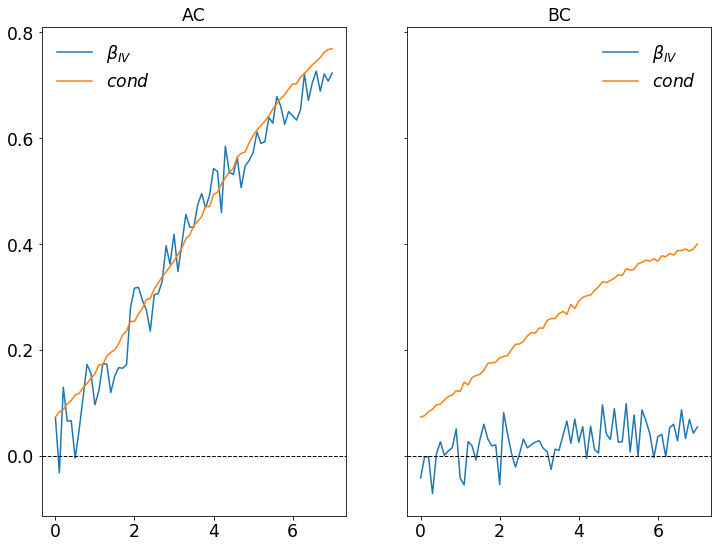

In [120]:
fig, axs = plt.subplots(1, 2, sharey=True)
axba, axbb = axs.flatten()
s = 1


axba.plot(amps, s * results['beta_AC'], label=r'$\beta_{IV}$')
# axba.plot(amps, (results['rate_C'] - results['rate_C'][0]) / (results['rate_A'] + results['rate_S']))

axbb.plot(amps, s * results['beta_BC'], label=r'$\beta_{IV}$')

axba.plot(amps, s * results['cond_AC'], label=r'$cond$')
axbb.plot(amps, s * results['cond_BC'], label=r'$cond$')

axba.axhline(0, color='k', lw=1, ls='--')
axbb.axhline(0, color='k', lw=1, ls='--')
axba.legend(frameon=False, loc=0)
axbb.legend(frameon=False, loc=0)
# axbb.set_xlabel('Connection strength AC')
axba.set_title('AC')
axbb.set_title('BC')


In [53]:
i = 70

stim_times = simulations['stim_times'][i]
A_spikes = simulations['A_spikes'][i]
B_spikes = simulations['B_spikes'][i]
C_spikes = simulations['C_spikes'][i]
stop_time = simulations['stop_time'][i]
print(simulations['J_AC'][i])

Z, X, Y, stim_times = calculate_regressors(B_spikes, C_spikes, stim_times)

7.0


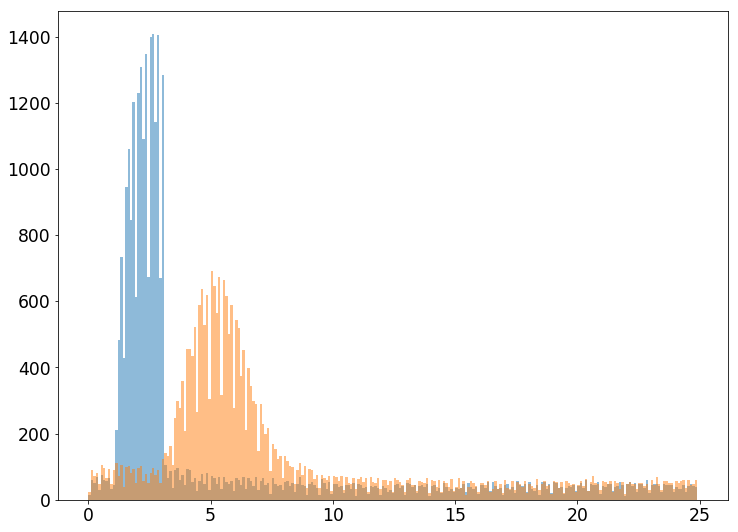

In [54]:
binsize = .1
bins = np.arange(0, 25, binsize)
plt.hist(X, bins=bins, alpha=.5);
plt.hist(Y, bins=bins, alpha=.5);

In [55]:
x = B_spikes
y = C_spikes
z1 = 1

stim_times = stim_times.astype(float)

src_x = np.searchsorted(x, stim_times, side='right')
src_y = np.searchsorted(y, stim_times, side='right')

remove_idxs, = np.where(
    (src_x==len(x)) | (src_y==len(y)))
src_x = np.delete(src_x, remove_idxs)
src_y = np.delete(src_y, remove_idxs)
stim_times = np.delete(stim_times, remove_idxs)

X = x[src_x] - stim_times
Y = y[src_y] - stim_times
Z = x[src_x-1] - stim_times
Yn = y[src_y-1] - stim_times

ZZ = (abs(Z) < z1).astype(int)

X0 = np.concatenate([Z[ZZ==0], X[ZZ==0]])
X1 = np.concatenate([Z[ZZ==1], X[ZZ==1]])
Y0 = np.concatenate([Yn[ZZ==0], Y[ZZ==0]])
Y1 = np.concatenate([Yn[ZZ==1], Y[ZZ==1]])

(-20, 20)

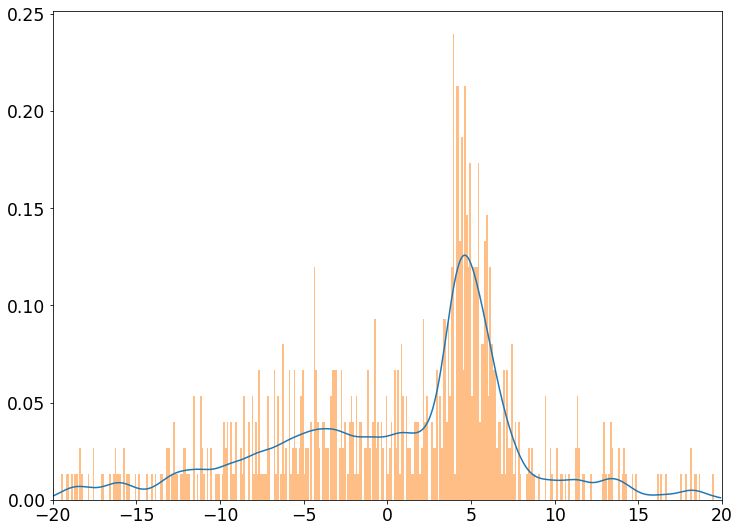

In [63]:
kernel_y1 = st.gaussian_kde(Y1[(Y1 > -20) & (Y1 < 20)], .1)
x = np.arange(-20,20,.1)
plt.plot(x, kernel_y1(x))
plt.hist(Y1, bins=x, alpha=.5, density=True);
plt.xlim(-20,20)

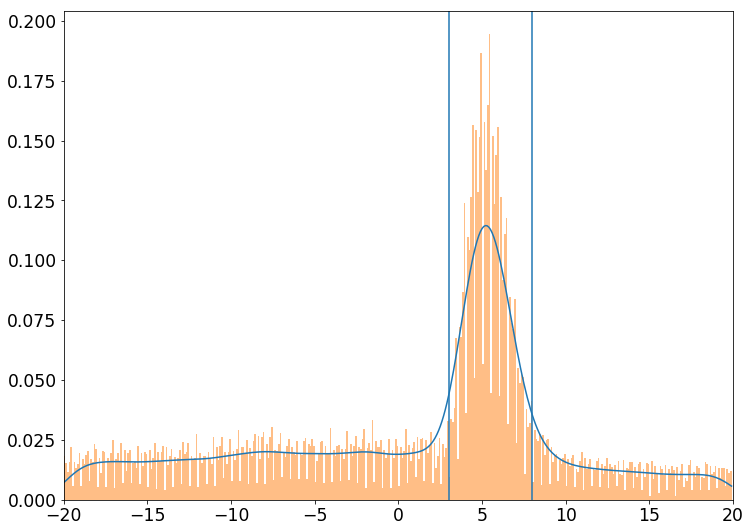

In [70]:
kernel_y0 = st.gaussian_kde(Y0[(Y0 > -20) & (Y0 < 20)], .1)
x = np.arange(-20,20,.1)
plt.plot(x, kernel_y0(x))
plt.hist(Y0, bins=x, alpha=.5, density=True);
plt.xlim(-20,20)
plt.axvline(3)
plt.axvline(8)

(-20, 20)

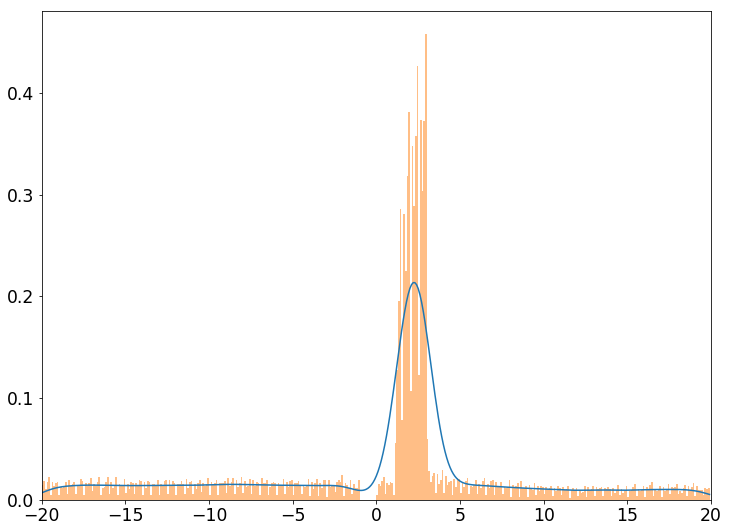

In [66]:
kernel_x0 = st.gaussian_kde(X0[(X0 > -20) & (X0 < 20)], .1)
x = np.arange(-20,20,.1)
plt.plot(x, kernel_x0(x))
plt.hist(X0, bins=x, alpha=.5, density=True);
plt.xlim(-20,20)

In [71]:
(kernel_y0.integrate_box(3,8) - kernel_y1.integrate_box(3,8)) / kernel_x0.integrate_box(1,3)

-5.2924448012883516e-05

In [367]:
kernel.integrate_box(-5,-3)

0.042637329290739344

In [27]:
True==1

True